In [1]:
library(ggplot2)
library(tidyverse)
library(janitor)
library(dplyr)
library(pROC)
library(caret)
library(nnet)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [2]:
undersampling_data <- read.csv(file = "../data/undersampled_data.csv")
oversampling_data <- read.csv(file = "../data/oversampled_data.csv")
smote_data <- read.csv(file = "../data/smote_augmented_data_80_percent.csv")
cleaned_data <- read.csv(file = "../data/cleaned_data.csv")

In [7]:
process_data <- function(data) {
  # Clean column names
  data <- clean_names(data)
  
  # Hàm để phân loại BMI
  categorize_bmi <- function(bmi) {
    if (bmi < 18.5) {
      return('Underweight')
    } else if (bmi >= 18.5 & bmi < 24.9) {
      return('Normal weight')
    } else if (bmi >= 25 & bmi < 29.9) {
      return('Overweight')
    } else if (bmi >= 30 & bmi < 34.9) {
      return('Obesity class 1')
    } else if (bmi >= 35 & bmi < 39.9) {
      return('Obesity class 2')
    } else {
      return('Obesity class 3')
    }
  }
  
  # Tạo cột mới bmi_category cho dataframe data
  data$bmi_category <- sapply(data$bmi, categorize_bmi)
  # Chuyển đổi bmi_category thành factor với các levels cụ thể
  data$bmi_category <- factor(data$bmi_category, levels = c('Underweight', 'Normal weight', 'Overweight', 'Obesity class 1', 'Obesity class 2', 'Obesity class 3'))
  

  # Xóa các cột không cần thiết
  data <- within(data, rm("bmi", "ment_hlth"))
  
  # Chuyển đổi các biến không định lượng thành factor
  quantitative_vars <- c("phys_hlth")

  non_quantitative_vars <- setdiff(names(data), quantitative_vars)
  data[non_quantitative_vars] <- lapply(data[non_quantitative_vars], factor)

  # Chuyển đổi biến diabetes_012 thành 3 biến nhị phân
  data$is_diabetes <- as.numeric(data$diabetes_012 == 2)
  data$is_prediabetes <- as.numeric(data$diabetes_012 == 1)
  data$is_no_diabetes <- as.numeric(data$diabetes_012 == 0)

  # Sắp xếp lại cột
  other_cols <- setdiff(names(data), c("diabetes_012", "is_diabetes", "is_prediabetes", "is_no_diabetes"))
  data <- data[, c(other_cols, "diabetes_012", "is_diabetes", "is_prediabetes", "is_no_diabetes")]
  
  return(data)
}


set.seed(42) 

train_test_split <- function(data, train_ratio = 0.8) {
    train_indices <- sample(seq_len(nrow(data)), size = floor(train_ratio * nrow(data)), replace = FALSE)
    train_data <- data[train_indices, ]
    test_data <- data[-train_indices, ]
    res <- list(
        train_data = train_data,
        test_data = test_data
    )
    return(res)
}


In [8]:
undersampling_data <- process_data(undersampling_data)
oversampling_data <- process_data(oversampling_data)
smote_data <- process_data(smote_data)
cleaned_data <- process_data(cleaned_data)


Warning message in Ops.factor(bmi, 18.5):
“‘<’ not meaningful for factors”


ERROR: Error in if (bmi < 18.5) {: missing value where TRUE/FALSE needed


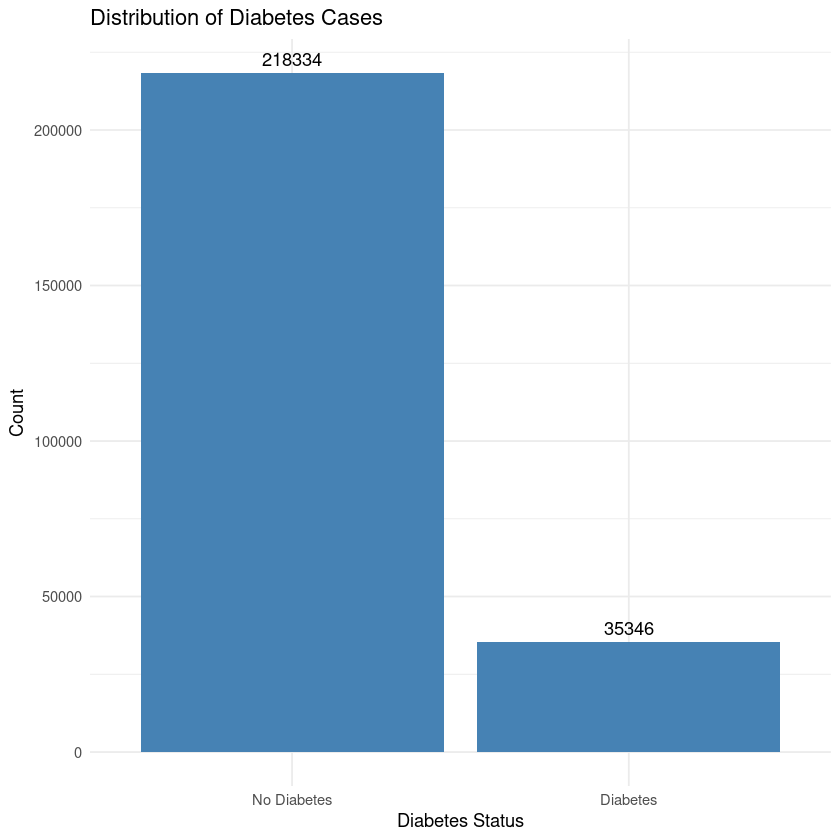

In [11]:
ggplot(cleaned_data, aes(x = factor(is_diabetes))) +
    geom_bar(fill = "steelblue") +
    geom_text(stat = 'count', aes(label = ..count..), vjust = -0.5) +
    labs(x = "Diabetes Status", y = "Count",
             title = "Distribution of Diabetes Cases") +
    scale_x_discrete(labels = c("No Diabetes", "Diabetes")) +
    theme_minimal()

In [13]:
library(ROSE)
set.seed(42)

# Use is_diabetes as the binary target variable
# Perform ROSE sampling
smote_balanced <- ROSE(is_diabetes ~ ., data = cleaned_data, seed = 42, N = nrow(cleaned_data), p = 0.5)$data

# Print class distribution after ROSE
table(smote_balanced$is_diabetes)


     0      1 
127077 126603 

In [20]:
# Undersampling
under_balanced <- ROSE(is_diabetes ~ ., data = cleaned_data, seed = 42, 
                      N = 2 * sum(cleaned_data$is_diabetes == 1), 
                      p = 0.5)$data

# Print class distribution after balancing
cat("Undersampling distribution:\n")
table(under_balanced$is_diabetes)

# Oversampling
over_balanced <- ROSE(is_diabetes ~ ., data = cleaned_data, seed = 42,
                     N = 2 * sum(cleaned_data$is_diabetes == 0),
                     p = 0.5)$data


cat("\nOversampling distribution:\n")
table(over_balanced$is_diabetes)

Undersampling distribution:



    0     1 
35228 35464 


Oversampling distribution:



     0      1 
218166 218502 

# Modeling

## Binary

In [ ]:
# List of datasets to evaluate
datasets <- list(
    "Original Data" = cleaned_data,
    "Oversampled Data" = over_balanced,
    "Undersampled Data" = under_balanced,
    "SMOTE Data" = smote_balanced
)

# Store results
results <- data.frame(
    Dataset = character(),
    Accuracy = numeric(),
    Sensitivity = numeric(),
    Specificity = numeric(),
    stringsAsFactors = FALSE
)

# Loop through each dataset
for (dataset_name in names(datasets)) {
    data <- datasets[[dataset_name]]
    label = "is_diabetes"
    
    # Split data
    train_data <- train_test_split(data)$train_data
    test_data <- train_test_split(data)$test_data
    
    # Define predictors
    predictors <- names(data)[!names(data) %in% 
                                   c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]
    
    # Create formula
    formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))
    
    # Fit model
    logistic_model <- glm(formula, data = train_data, family = "binomial")
    
    # Make predictions
    predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
    predictions <- ifelse(predictions_prob > 0.5, 1, 0)
    
    # Calculate metrics
    accuracy <- mean(predictions == test_data$is_diabetes)
    sensitivity <- sum(predictions == 1 & test_data$is_diabetes == 1) / sum(test_data$is_diabetes == 1)
    specificity <- sum(predictions == 0 & test_data$is_diabetes == 0) / sum(test_data$is_diabetes == 0)
    
    # Store results
    results <- rbind(results, data.frame(
        Dataset = dataset_name,
        Accuracy = round(accuracy, 4),
        Sensitivity = round(sensitivity, 4),
        Specificity = round(specificity, 4)
    ))
}
# Display results
print(results)

            Dataset Accuracy Sensitivity Specificity
1     Original Data   0.8659      0.1710      0.9782
2  Oversampled Data   0.7499      0.7808      0.7187
3 Undersampled Data   0.7460      0.7779      0.7139
4        SMOTE Data   0.7462      0.7736      0.7194


In [32]:
data = over_balanced
label = "is_diabetes"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- glm(formula, data = train_data, family = "binomial")
# summary(logistic_model)

predictions_prob <- predict(logistic_model, newdata = test_data, type = "response")
predictions <- ifelse(predictions_prob > 0.451404, 1, 0)

accuracy <- mean(predictions == test_data$is_diabetes)
print(paste("Model Accuracy:", round(accuracy, 4)))
# Calculate sensitivity and specificity
sensitivity <- sum(predictions == 1 & test_data$is_diabetes == 1) / sum(test_data$is_diabetes == 1)
specificity <- sum(predictions == 0 & test_data$is_diabetes == 0) / sum(test_data$is_diabetes == 0)

print(paste("Sensitivity:", round(sensitivity, 4)))
print(paste("Specificity:", round(specificity, 4)))

[1] "Model Accuracy: 0.7501"
[1] "Sensitivity: 0.8203"
[1] "Specificity: 0.6796"


Prediction,Reference,Freq
<fct>,<fct>,<int>
0,0,29611
1,0,13963
0,1,7865
1,1,35895


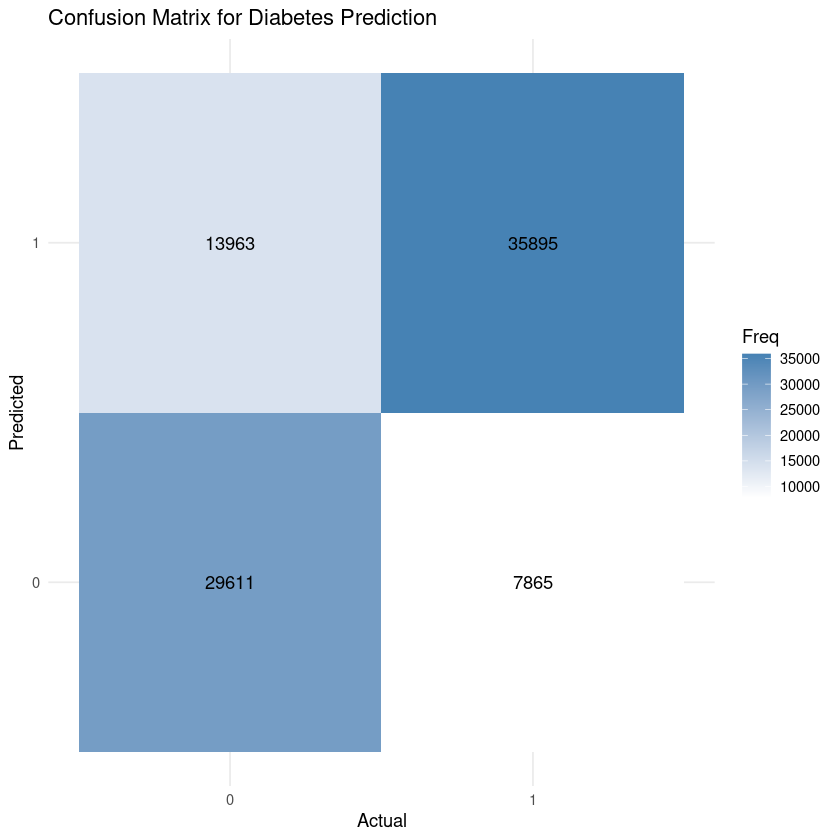

In [38]:
conf_matrix <- confusionMatrix(factor(predictions), factor(test_data$is_diabetes))

conf_data <- as.data.frame(conf_matrix$table)
conf_data
ggplot(conf_data, aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Diabetes Prediction",
             x = "Actual",
             y = "Predicted")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



95% CI: 0.8241-0.8295 (DeLong)


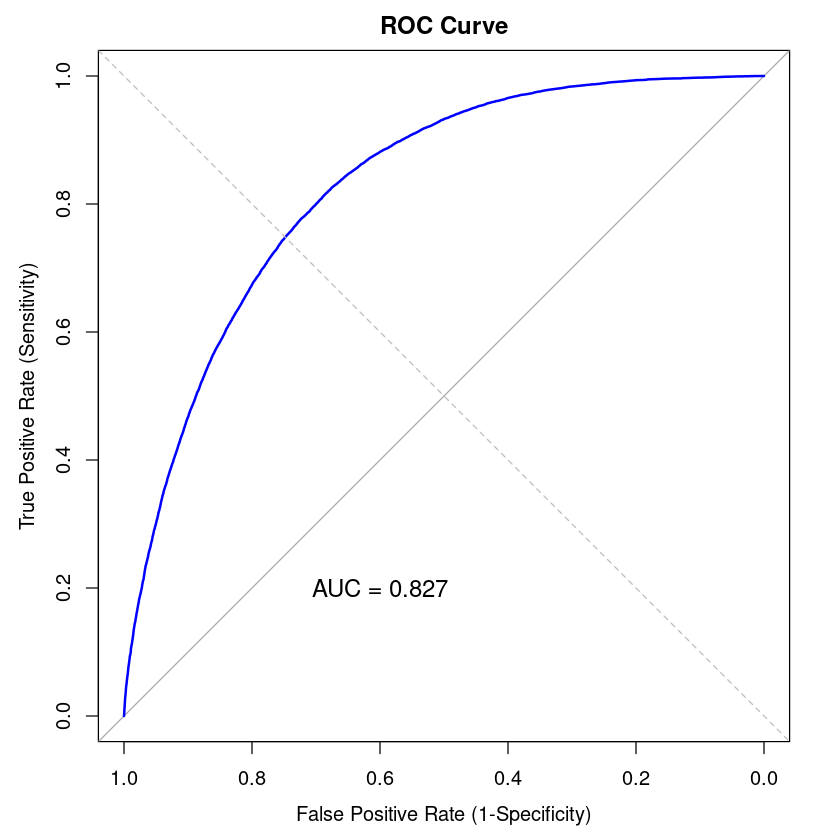

In [30]:
# Calculate ROC curve
roc_obj <- roc(test_data$is_diabetes, predictions_prob)
auc_value <- auc(roc_obj)
print(ci.auc(roc_obj,conf.level = 0.95))

# Plot ROC curve
plot(roc_obj, main = "ROC Curve",
    col = "blue", lwd = 2,
    xlab = "False Positive Rate (1-Specificity)",
    ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")

# Add AUC value to plot
text(0.6, 0.2, paste("AUC =", round(auc_value, 3)),
    col = "black", cex = 1.2)

In [31]:
# Lựa chọn ngưỡng tối ưu dựa trên phương pháp Youden Index
out_youd <- coords(roc_obj, "best", ret = c("threshold", "specificity", "sensitivity"),best.method = "youden")
print(out_youd)

  threshold specificity sensitivity
1  0.451404   0.6803762   0.8206406


In [33]:
out_youd <- coords(roc_obj, "best", ret = c("threshold", "specificity", "sensitivity"),best.method = "closest.topleft")
print(out_youd)

  threshold specificity sensitivity
1 0.5165103    0.734465   0.7641236


## Multiclass

In [9]:
data = undersampling_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)

# weights:  150 (98 variable)
initial  value 12209.976976 
iter  10 value 10985.482585
iter  20 value 10839.841197
iter  30 value 10613.732917
iter  40 value 10553.505075
iter  50 value 10506.822605
iter  60 value 10500.609718
iter  70 value 10498.819172
iter  80 value 10498.334185
iter  90 value 10498.099236
iter 100 value 10497.899960
final  value 10497.880890 
converged


$Precision
        0         1         2 
0.6171040 0.4586466 0.5188940 

$Recall
        0         1         2 
0.6677182 0.3404018 0.6040773 

$Accuracy
[1] 0.540842

$Kappa
[1] 0.3097402

$Macro_F1
[1] 0.5344576



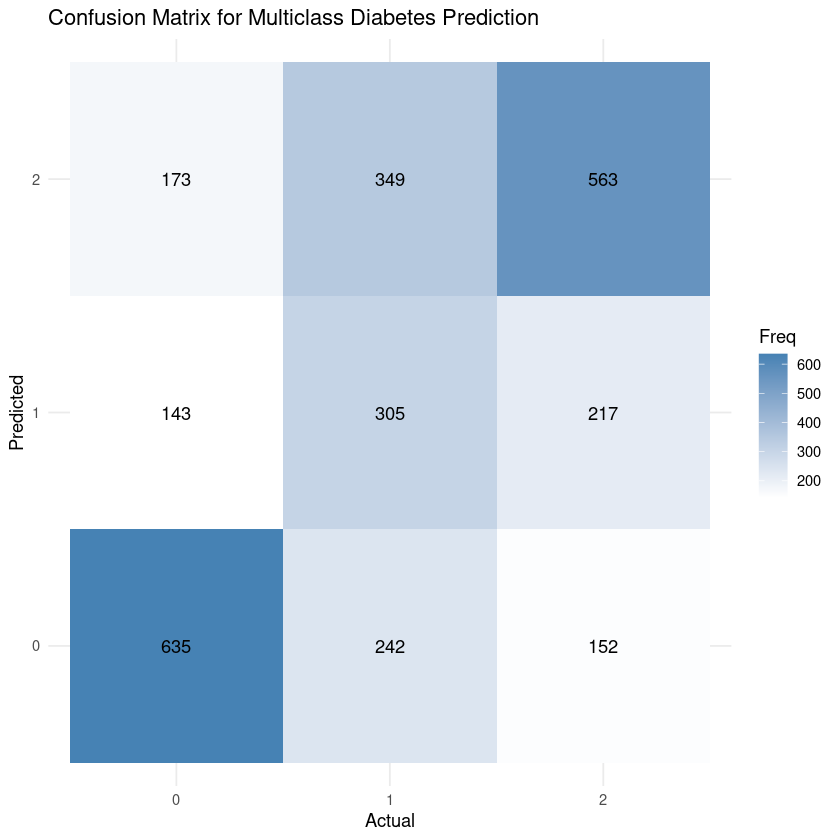

In [10]:
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Actual = test_data$diabetes_012,Predicted = predictions)

# Define evaluation function for multiclass metrics
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")

In [11]:
data = oversampling_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
summary(logistic_model)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Predicted = predictions, Actual = test_data$diabetes_012)


# weights:  150 (98 variable)
initial  value 488334.260924 
iter  10 value 434991.974948
iter  20 value 430094.488020
iter  30 value 429437.865309
iter  40 value 428809.429911
iter  50 value 427358.076650
iter  60 value 425773.373259
iter  70 value 421029.532763
iter  80 value 418316.697614
iter  90 value 417622.510251
iter 100 value 416395.823124
final  value 415763.197496 
converged


Call:
multinom(formula = formula, data = train_data, maxit = 1500)

Coefficients:
  (Intercept)  high_bp1 high_chol1 chol_check1     smoker1     stroke1
1   -4.569428 0.3371663  0.5609758   0.8368726 -0.02912333 -0.07616466
2   -5.989910 0.6947355  0.5810888   1.3145810 -0.04949087  0.15180731
  heart_diseaseor_attack1 phys_activity1     fruits1    veggies1
1               0.0204376    -0.02964728 -0.02034951 -0.05747849
2               0.2737272    -0.07768640 -0.02644723 -0.04124225
  hvy_alcohol_consump1 any_healthcare1 no_docbc_cost1 gen_hlth2 gen_hlth3
1           -0.1670651     -0.05566405      0.4121045 0.4710324 0.8556254
2           -0.8114527      0.07357653      0.1184216 0.7206881 1.4470853
  gen_hlth4 gen_hlth5     phys_hlth  diff_walk1       sex1      age2      age3
1  1.138602  1.007547  0.0007440633 -0.01273466 0.08943415 0.6015909 0.4446412
2  1.902967  2.031557 -0.0022784995  0.09687005 0.28133008 0.3094520 0.4431450
       age4      age5     age6     age7     age8   

Warning message in cc * sc:
“NAs produced by integer overflow”


$Precision
        0         1         2 
0.6113300 0.4234134 0.4937200 

$Recall
        0         1         2 
0.7182542 0.2548883 0.5837353 

$Accuracy
[1] 0.5335385

$Kappa
[1] NA

$Macro_F1
[1] 0.5141799



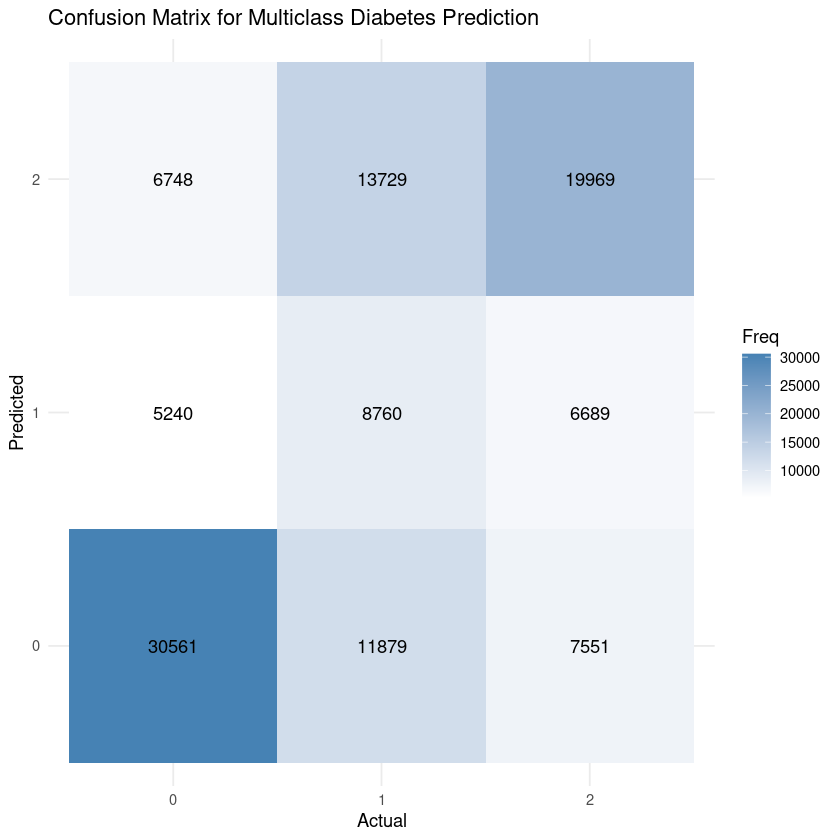

In [12]:
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Actual = test_data$diabetes_012,Predicted=predictions)

# Define evaluation function for multiclass metrics
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")


# weights:  150 (98 variable)
initial  value 488334.260924 
iter  10 value 431919.363292
iter  20 value 427147.455097
iter  30 value 426464.713758
iter  40 value 425691.272623
iter  50 value 424007.096409
iter  60 value 419217.036989
iter  70 value 416620.814100
iter  80 value 410017.916881
iter  90 value 409446.537038
iter 100 value 407963.974079
iter 110 value 407614.680430
iter 110 value 407614.680025
iter 110 value 407614.680024
final  value 407614.680024 
converged


Warning message in cc * sc:
“NAs produced by integer overflow”


$Precision
        0         1         2 
0.7182354 0.3247480 0.5615823 

$Recall
        0         1         2 
0.6228271 0.4643199 0.5056319 

$Accuracy
[1] 0.5487015

$Kappa
[1] NA

$Macro_F1
[1] 0.5328835



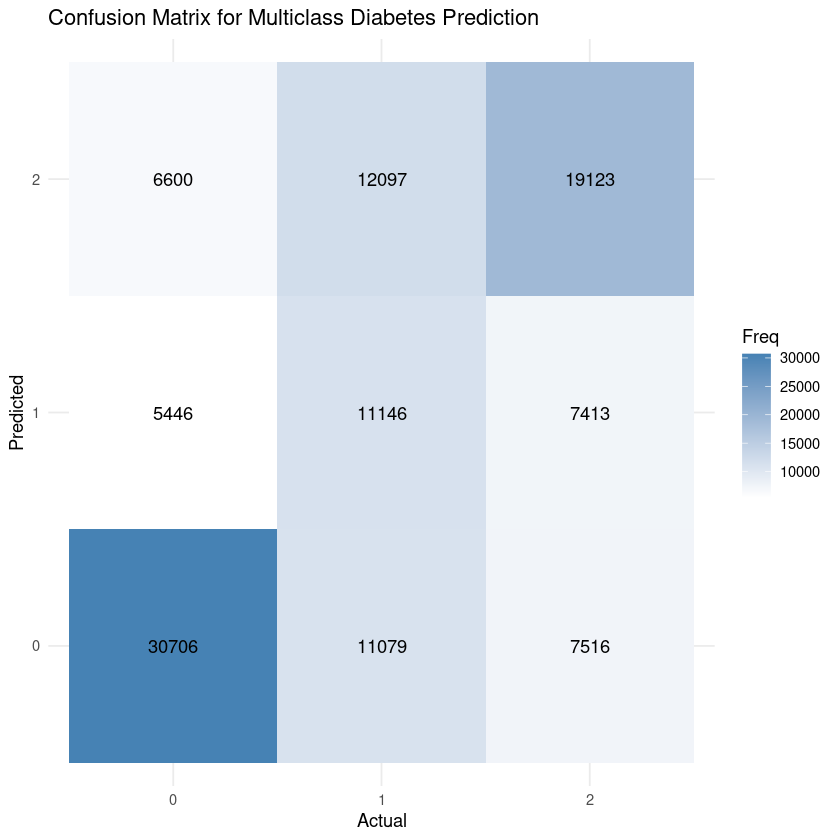

In [13]:
data = smote_data
label = "diabetes_012"

train_data <- train_test_split(data)$train_data
test_data <- train_test_split(data)$test_data

predictors <- names(data)[!names(data) %in% 
                               c("is_diabetes", "is_prediabetes", "is_no_diabetes", "diabetes_012")]

formula <- as.formula(paste(label,"~", paste(predictors, collapse = " + ")))

logistic_model <- multinom(formula, data = train_data, maxit=1500)
# Get predictions
predictions <- predict(logistic_model, newdata = test_data)

# Create confusion matrix
conf_matrix <- table(Predicted = predictions, Actual = test_data$diabetes_012)

# Define evaluation function
eval_metrics <- function(x) {
    cc <- sum(diag(x))
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    # Calculate metrics
    prec <- diag(x)/colSums(x)
    recall <- diag(x)/rowSums(x)
    macro_prec <- mean(prec)
    macro_recall <- mean(recall)
    macro_f1 <- 2 * macro_prec * macro_recall/(macro_prec + macro_recall)
    acc <- cc/sc
    kap <- (cc * sc - sum(pp * tt))/(sc^2 - sum(pp * tt))
    
    return(list(
        Precision = prec,   
        Recall = recall,
        Accuracy = acc,
        Kappa = kap,
        Macro_F1 = macro_f1
    ))
}

# Calculate and display metrics
metrics <- eval_metrics(conf_matrix)
print(metrics)

# Visualize confusion matrix
conf_data <- as.data.frame(conf_matrix)
ggplot(conf_data, aes(x = Actual, y = Predicted)) +
    geom_tile(aes(fill = Freq)) +
    geom_text(aes(label = Freq)) +
    scale_fill_gradient(low = "white", high = "steelblue") +
    theme_minimal() +
    labs(title = "Confusion Matrix for Multiclass Diabetes Prediction",
         x = "Actual",
         y = "Predicted")
